# Import Library

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load data

In [2]:
data=pd.read_csv('2025_groupe4\mass_31012025.csv',comment='#', delim_whitespace=True)
data

,X_Value,Channel4,Channel3,Channel2,Channel1
0,0.000000e+00,-0.0072,-0.0008,-0.0040,0.0020
1,2.000000e-10,-0.0080,-0.0008,-0.0036,0.0020
2,4.000000e-10,-0.0088,-0.0008,-0.0032,0.0020
3,6.000000e-10,-0.0084,-0.0016,-0.0036,0.0020
4,8.000000e-10,-0.0076,-0.0012,-0.0036,0.0020
...,...,...,...,...,...
2540630,2.640247e+05,-0.0076,-0.0012,-0.0052,0.0024
2540631,2.640247e+05,-0.0080,-0.0012,-0.0044,0.0024
2540632,2.640247e+05,-0.0076,-0.0016,-0.0028,0.0040
2540633,2.640247e+05,-0.0080,-0.0012,-0.0028,0.0044


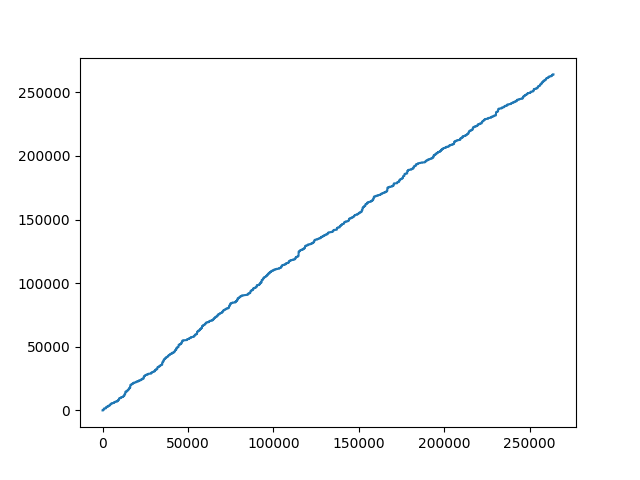

In [3]:
x=np.linspace(0,data['X_Value'].max(),len(data['X_Value']))
y=data['X_Value']
plt.plot(x,y)

In [4]:
# Detect large jumps (discontinuities)
dy = np.abs(np.diff(y))  # Compute absolute differences
threshold = np.mean(dy) + 1 * np.std(dy)  # Adaptive threshold
discontinuity_indices = np.where(dy > threshold)[0]
#print(discontinuity_indices)

# Extract x-values where discontinuities occur
discontinuity_x = x[discontinuity_indices+1]  

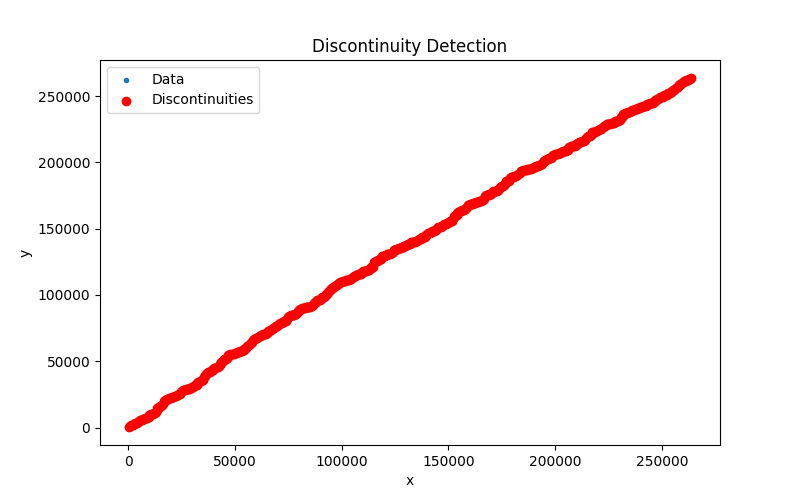

In [5]:
# Plotting
plt.figure(figsize=(8, 5))
plt.scatter(x, y, label='Data',marker='.')
plt.scatter(discontinuity_x, y[discontinuity_indices], color='red', label='Discontinuities', zorder=3)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Discontinuity Detection')
plt.show()

# Print detected discontinuities
# print("Discontinuity detected at x-values:", discontinuity_x)

# Plot Events

In [6]:
events = np.insert(discontinuity_indices+1,0,0)
len(events)

618

In [7]:
times=data['X_Value'].iloc[events[0]:events[0+1]]
i=617

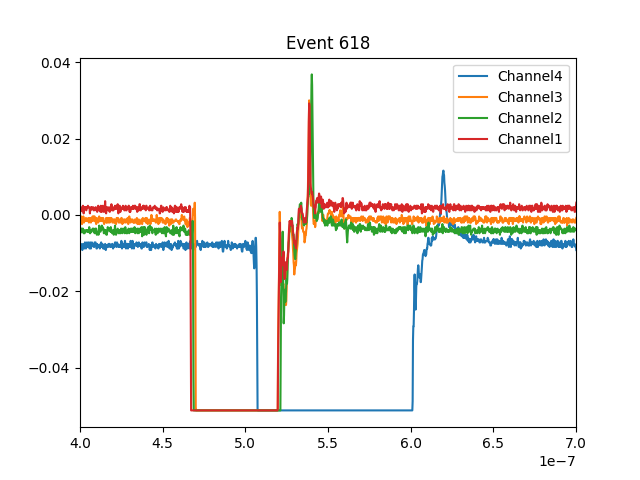

In [8]:
# for i in range(len(events)):
plt.figure()
plt.title(f'Event {i+1}')
for column in data.columns[1:]:
    if i == len(events)-1:
        # print(data[column].iloc[events[i]:])
        plt.plot(times,data[column].iloc[events[i]:],label=column)
    else:
        # print(data[column].iloc[events[i]:events[i+1]])
        plt.plot(times,data[column].iloc[events[i]:events[i+1]],label=column)
plt.xlim((4e-7,7e-7))
plt.legend(loc='best')
plt.show()

# Another way to separate events

Stored in a list

Adding a column for `event_ID` and repeated the `X_Value` of the first event for all events

In [9]:
# Define event size
event_size = 4001

# Ensure the DataFrame can be evenly split
num_events = len(data) // event_size
print(f'Expected number of events: {num_events}')

# Assign an Event_ID column to the DataFrame
data = data.iloc[:num_events * event_size].copy()  # Trim excess rows if any
data['Event_ID'] = data.index // event_size

# Replace 'X_Value' for all events with 'times' from event 0
times = data[data['Event_ID'] == 0]['X_Value'].values
data['X_Value'] = np.tile(times, num_events)

# # Optionally, store each event in separate CSV files
# for event_id in range(num_events):
#     event_data = data[data['Event_ID'] == event_id]
#     event_data.to_csv(f"event_{event_id + 1}.csv", index=False)

# Print confirmation
print(f"Total events extracted: {len(events)}")

data

Expected number of events: 635
Total events extracted: 618


,X_Value,Channel4,Channel3,Channel2,Channel1,Event_ID
0,0.000000e+00,-0.0072,-0.0008,-0.0040,0.0020,0
1,2.000000e-10,-0.0080,-0.0008,-0.0036,0.0020,0
2,4.000000e-10,-0.0088,-0.0008,-0.0032,0.0020,0
3,6.000000e-10,-0.0084,-0.0016,-0.0036,0.0020,0
4,8.000000e-10,-0.0076,-0.0012,-0.0036,0.0020,0
...,...,...,...,...,...,...
2540630,7.992000e-07,-0.0076,-0.0012,-0.0052,0.0024,634
2540631,7.994000e-07,-0.0080,-0.0012,-0.0044,0.0024,634
2540632,7.996000e-07,-0.0076,-0.0016,-0.0028,0.0040,634
2540633,7.998000e-07,-0.0080,-0.0012,-0.0028,0.0044,634


In [13]:
num_event=48
by_event=data.groupby(data.Event_ID)
event=(by_event.get_group(num_event)).drop(columns=['Event_ID'])
event.X_Value

192048    0.000000e+00
192049    2.000000e-10
192050    4.000000e-10
192051    6.000000e-10
192052    8.000000e-10
              ...     
196044    7.992000e-07
196045    7.994000e-07
196046    7.996000e-07
196047    7.998000e-07
196048    8.000000e-07
Name: X_Value, Length: 4001, dtype: float64

<AxesSubplot: title={'center': 'Event 48'}, xlabel='X_Value'>

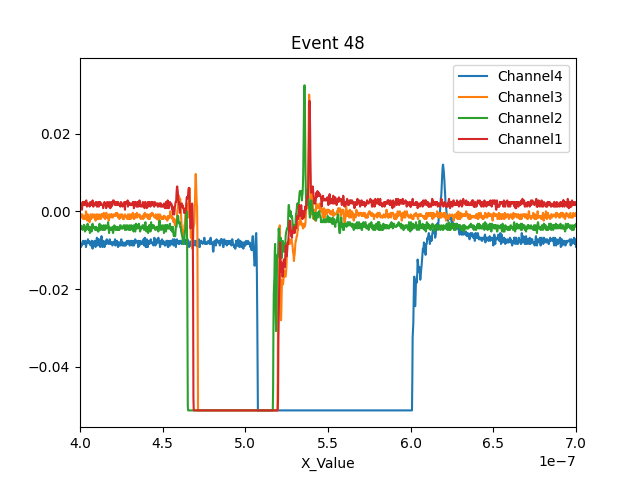

In [14]:
event.plot(x='X_Value', y=['Channel4','Channel3','Channel2','Channel1'],
           xlim=(4e-7,7e-7),
           title='Event '+str(num_event))

# Determination of the velocity 

# Determination of the mass